# Case 1. Categorical simulation with pyramids

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import ot

from mpstool import connectivity, stats
from geone import img, imgplot, deesseinterface

from utils import save_computation

In [2]:
%load_ext autoreload
%autoreload 1
%aimport ensemble, simulator, scoring

## Training image

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x7f01293531c0>)

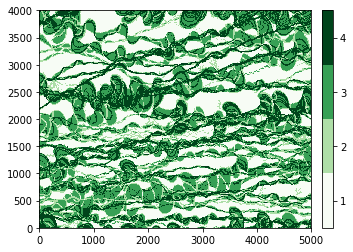

In [3]:
ti = img.readImageGslib('data/ti_4cat_wl375_2.gslib')
imgplot.drawImage2D(ti, categ=True, cmap=plt.cm.get_cmap('Greens', 4))

## Reference ensemble

In [4]:
ref_ensemble = ensemble.Ensemble.from_ti(ti=ti,
                                         x_size=200,
                                         y_size=200,
                                         size=400,
                                         seed=123)

In [5]:
def categorical_plot(fig, ax, image):
    mpb = ax.imshow(image, cmap=plt.cm.get_cmap('Greens', 4), origin='lower', vmin=0.5, vmax=4.5)
    ax.set_xticks([0, 200])
    ax.set_yticks([0, 200])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size='5%', pad='5%')    
    fig.colorbar(mpb, cax=cax, ax=ax, ticks=[1,2,3,4])
    return mpb
    

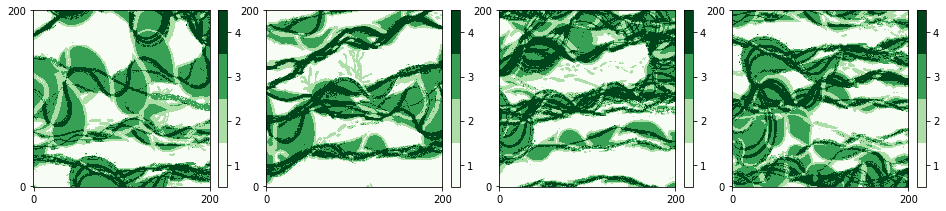

In [6]:
fig, axes = plt.subplots(1,4, figsize=(16,4))
for i, ax in enumerate(axes):
    categorical_plot(fig, ax, ref_ensemble[i])

## DS ensembles and parameters

In [7]:
def load_ensembles(row, simulator_class):
    simulator_obj = simulator_class(nneighboringNode=row['nneighboringNode'],
                 distanceThreshold=row['distanceThreshold'],
                 maxScanFraction=row['maxScanFraction'],
                 root_dir='ds')
    
    ensemble, timing = simulator_obj.get_ensemble(ti,
                                                  ensemble_size=40,
                                                  nthreads=40,
                                                  seed=444,
                                                  overwrite=True)
    row['timing'] = timing
    for function in (connectivity.get_function, stats.variogram):
        f = lambda x: function(x, axis=1)
        row[f'ot_{function.__name__}'] = scoring.avg_ot(ref_ensemble, ensemble, f)
    
    return row

In [8]:
def compute_scores(df, simulator_class):
    return df.apply(lambda row: load_ensembles(row, simulator_class), axis=1)

In [9]:
parameter_sets = [ [n, i/n] for n in [8, 16, 32, 64]
                  for i in range(1, n//4 +1)]

df_ds_parameters = pd.DataFrame(parameter_sets,
                                columns = ['nneighboringNode',
                                           'distanceThreshold'])
df_ds_parameters['maxScanFraction'] = 0.25
df_ds_parameters.head()

,nneighboringNode,distanceThreshold,maxScanFraction
0,8,0.1250,0.25
1,8,0.2500,0.25
2,16,0.0625,0.25
3,16,0.1250,0.25
4,16,0.1875,0.25


In [10]:
df_ds = pd.read_csv('df_ds_latest.csv', index_col=0)

In [11]:
compute_scores_ds = save_computation(compute_scores, 'df_ds.pickle')
df_ds = compute_scores_ds(df_ds_parameters, simulator.DS)
df_ds.head()

,nneighboringNode,distanceThreshold,maxScanFraction,timing,ot_get_function,ot_variogram
0,8.0,0.1250,0.25,129.887071,0.022746,0.005126
1,8.0,0.2500,0.25,88.621959,0.026524,0.007604
2,16.0,0.0625,0.25,410.775545,0.005569,0.000336
3,16.0,0.1250,0.25,269.496509,0.013744,0.003312
4,16.0,0.1875,0.25,125.249846,0.020053,0.011962


## DSBC ensembles

In [12]:
f_values = [1/i for i in [8, 16, 32, 64, 128, 256]]
n_values = [8, 16, 32, 64]
parameter_sets = [[i,j] for i in n_values for j in f_values] 

df_dsbc_parameters = pd.DataFrame(parameter_sets, columns=['nneighboringNode', 'maxScanFraction'])
df_dsbc_parameters['distanceThreshold'] = 0
df_dsbc_parameters.head()

,nneighboringNode,maxScanFraction,distanceThreshold
0,8,0.125000,0
1,8,0.062500,0
2,8,0.031250,0
3,8,0.015625,0
4,8,0.007812,0


In [13]:
compute_scores_dsbc = save_computation(compute_scores, 'df_dsbc.pickle')
df_dsbc = compute_scores_dsbc(df_dsbc_parameters, simulator.DSBC)
df_dsbc.head()

,nneighboringNode,maxScanFraction,distanceThreshold,timing,ot_get_function,ot_variogram
0,8.0,0.125000,0.0,596.812558,0.014538,0.000985
1,8.0,0.062500,0.0,354.630691,0.015447,0.001073
2,8.0,0.031250,0.0,194.485949,0.026147,0.004377
3,8.0,0.015625,0.0,119.426028,0.036224,0.007719
4,8.0,0.007812,0.0,175.668396,0.037183,0.008455


## Analysis

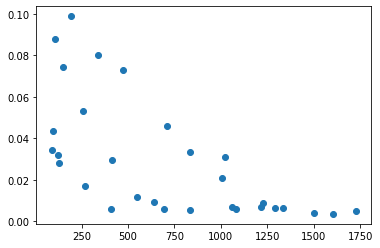

In [14]:
plt.scatter(x=df_ds['timing'], y=df_ds['ot_variogram']+df_ds['ot_get_function'])

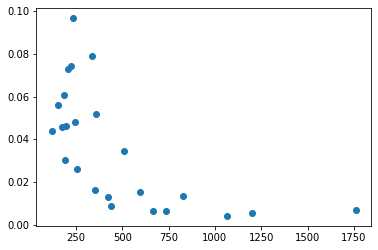

In [15]:
plt.scatter(x=df_dsbc['timing'], y=df_dsbc['ot_variogram']+df_dsbc['ot_get_function'])